# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [314]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split

### 데이터 셋 읽어오기

In [315]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [316]:
df_train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,customer_job,lead_desc_length,inquiry_type,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,NaN,purchasing,62,Quotation or purchase consultation,multi-split,NaN,NaN,/Quezon City/Philippines,entry level,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,NaN,media and communication,96,Quotation or purchase consultation,multi-split,NaN,NaN,/PH-00/Philippines,ceo/founder,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,NaN,engineering,56,Product Information,single-split,NaN,NaN,/Kolkata /India,partner,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,NaN,entrepreneurship,44,Quotation or purchase consultation,vrf,NaN,NaN,/Bhubaneswar/India,ceo/founder,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,NaN,consulting,97,Quotation or purchase consultation,multi-split,NaN,NaN,/Hyderabad/India,partner,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


## 2. 데이터 전처리

In [317]:
print(df_train.shape, df_test.shape)

(59299, 29) (5271, 30)


# 중복 제거

In [318]:
df_train.drop_duplicates(inplace=True)

In [319]:
print(df_train.shape, df_test.shape)

(55780, 29) (5271, 30)


### 무조건 converted하면서 test에 없는 회사인 25096은 삭제

In [320]:
del_id=[25096]
df_train=df_train[~df_train["customer_idx"].isin(del_id)]

In [321]:
df_train = df_train[(df_train["business_unit"] != "CM") & (df_train["business_unit"] != "Solution")]

In [322]:
def preprocess_customer_position(x):
    if x == 'c-levelexecutive' :
        return 'c-level executive'
    elif x == 'other':
        return 'others'
    else:
        return x
    
df_train['customer_position'] = df_train['customer_position'].apply(preprocess_customer_position)
df_test['customer_position'] = df_test['customer_position'].apply(preprocess_customer_position)

In [323]:
def preprocess_customer_position(df):
    # 가장 많이 나오는 변수 상위 5개를 저장
    top3_positions = df['customer_position'].value_counts().index[:15]

    # 상위 3개에 속하지 않는 경우 'others'로 변경
    df['customer_position'] = df['customer_position'].apply(lambda x: x if x in top3_positions else 'others')

    return df

# 함수를 훈련 데이터와 테스트 데이터에 적용
df_train = preprocess_customer_position(df_train)
df_test = preprocess_customer_position(df_test)

In [324]:
# 뭔가 train에 없는 것들 없애보려고 했는데 그닥
refin_col_list=[
    # 'business_area',
    # 'business_subarea',
    # 'response_corporate',
    # 'product_category',
    # 'product_subcategory',
    # 'product_modelname',
    'customer_position',
    'customer_type',
    # 'customer_job',
    # 'inquiry_type',
    # 'customer_position'
]
for col in refin_col_list:
    # df_train의 값이 df_test에 없는 행을 삭제하는 코드
    df_train = df_train[df_train[col].isin(df_test[col])]


In [325]:
print(df_train.shape, df_test.shape)

(52155, 29) (5271, 30)


### 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 회사별로 계산

In [326]:
df_cus = df_train.groupby("customer_idx")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("customer_idx")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="customer_idx")
df["cus_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "cus_query_cnt", "is_converted_y" : "cus_converted_cnt"})
df = df[df["cus_query_cnt"]>=2] 
df_train = pd.merge(df_train, df, on='customer_idx', how="left")
df_test = pd.merge(df_test, df, on='customer_idx', how="left")

### 문의를 받은 횟수, 문의 중에 converted 된 횟수, converted한 비율을 담당자 별로 계산

In [327]:
df_cus = df_train.groupby("lead_owner")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("lead_owner")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="lead_owner")
df["lead_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "lead_query_cnt", "is_converted_y" : "lead_converted_cnt"})
df=df[df["lead_query_cnt"]>=2]  
df_train = pd.merge(df_train, df, on='lead_owner', how="left")
df_test = pd.merge(df_test, df, on='lead_owner', how="left")

### 문의를 받은 횟수, 문의 중에 converted 된 횟수, converted한 비율을 담당 부서 별로 계산

In [328]:
df_cus = df_train.groupby("response_corporate")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("response_corporate")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="response_corporate")
df["rc_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "rc_query_cnt", "is_converted_y" : "rc_converted_cnt"})
print(df.head())
df=df[df["rc_query_cnt"]>=2]  
df_train = pd.merge(df_train, df, on='response_corporate', how="left")
df_test = pd.merge(df_test, df, on='response_corporate', how="left")

  response_corporate  rc_query_cnt  rc_converted_cnt  rc_ratio
0              LGEAF           180                28  0.155556
1              LGEAG             8                 0  0.000000
2              LGEAP           320                28  0.087500
3              LGEAR           468                65  0.138889
4              LGEAS            32                 1  0.031250


In [329]:
df_train.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_country.1', 'customer_position',
       'response_corporate', 'expected_timeline', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area',
       'business_subarea', 'lead_owner', 'is_converted', 'cus_query_cnt',
       'cus_converted_cnt', 'cus_ratio', 'lead_query_cnt',
       'lead_converted_cnt', 'lead_ratio', 'rc_query_cnt', 'rc_converted_cnt',
       'rc_ratio'],
      dtype='object')

In [330]:
df_cus = df_train.groupby("customer_position")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("customer_position")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="customer_position")
df["cus_pos_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "cus_pos_query_cnt", "is_converted_y" : "cus_pos_converted_cnt"})
print(df.head())
df=df[df["cus_pos_query_cnt"]>=2]  
df_train = pd.merge(df_train, df, on='customer_position', how="left")
df_test = pd.merge(df_test, df, on='customer_position', how="left")

   customer_position  cus_pos_query_cnt  cus_pos_converted_cnt  cus_pos_ratio
0  associate/analyst               2291                    135       0.058926
1  c-level executive                770                     32       0.041558
2        ceo/founder               7261                    270       0.037185
3           director               4427                    169       0.038175
4        entry level               2057                     51       0.024793


### 47466 도 이상한 회사야 그래서 이 회사인지 아닌지 

In [331]:
def change_value(x):
    if x == 47466:
        return 1
    else:
        return 0

df_train['customer_idx_47466'] = df_train['customer_idx'].apply(change_value)
df_test['customer_idx_r_47466'] = df_test['customer_idx'].apply(change_value)

coutnry_name 쪼개는 코드

In [332]:
# 대충 한거임 좀더 신경써야함
def country_name(x):
    if pd.isnull(x):
        return 0
    else:
        a = x.split("/")[-1].strip()
        if 'Congo' in a:
            return 'Congo'
        elif '@' in a:
            return 'email'
        elif any(state in a for state in ['United States', 'CA', 'MO', 'FL', 'IL', 
                                          'SD', 'TX', 'NY', 'MA', 'UT', 'CO',
                                          'MI', 'TN', 'RJ', 'GA', 'SC', 'OR', 'NV',
                                          'NJ', 'VT', 'ND', 'KS', 'MN', 'VA']):
            return 'United States'
        elif 'Türkiye' in a:
            return 'Turkey'
        elif any(city in a for city in ['mumbai', 'odisha', 'lucknow', 'kerela', 'bangalore', 'gurgaon']):
            return 'India'
        elif a in ['5555', '48201', 'country', 'A'] :
            return 0
        elif a in ["Zip 98433", '9820HuntersvilleNC28078', '200 cabelLouisvilleKY40206', 'Jacksonville Florida'] :
            return 'United States'
        else:
            words = a.split()
            count_a = sum(1 for word in words)
            if count_a >= 3:
                return 'United States'
            else:
                return a

df_train["customer_country"]=df_train["customer_country"].apply(country_name)
df_train["customer_country.1"]=df_train["customer_country.1"].apply(country_name)
df_test["customer_country"]=df_test["customer_country"].apply(country_name)
df_test["customer_country.1"]=df_test["customer_country.1"].apply(country_name)

In [333]:
df_train['customer_country'].nunique()

184

### 6 customer_type: 이상한 것들 묶기

In [334]:
def preprocess_customer_type(x):
    if x == 'End-Customer' :
        return 'End Customer'
    elif x == 'Specifier/ Influencer' :
        return 'Specifier / Influencer'
    elif x =='Other' or x=='Others':
        return 'Etc.'
    elif x == 'Software/Soultion Provider' :
        return 'Software / Solution Provider'
    else:
        return x
    
df_train['customer_type'] = df_train['customer_type'].apply(preprocess_customer_type)
df_test['customer_type'] = df_test['customer_type'].apply(preprocess_customer_type)

In [335]:
def preprocess_customer_type(df):
    # 'End-Customer'를 'End Customer'로 변경
    df['customer_type'] = df['customer_type'].replace('End-Customer', 'End Customer')

    # 가장 많이 나오는 변수 상위 5개를 저장
    top3_types = df['customer_type'].value_counts().index[:5]

    # 상위 3개에 속하지 않는 경우 'others'로 변경
    df['customer_type'] = df['customer_type'].apply(lambda x: x if x in top3_types else 'others')

    return df

# 함수를 훈련 데이터와 테스트 데이터에 적용
df_train = preprocess_customer_type(df_train)
df_test = preprocess_customer_type(df_test)

In [336]:
df_cus = df_train.groupby("customer_type")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("customer_type")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="customer_type")
df["cus_type_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "cus_type_query_cnt", "is_converted_y" : "cus_type_converted_cnt"})
print(df.head())
df=df[df["cus_type_query_cnt"]>=2]  
df_train = pd.merge(df_train, df, on='customer_type', how="left")
df_test = pd.merge(df_test, df, on='customer_type', how="left")

            customer_type  cus_type_query_cnt  cus_type_converted_cnt  \
0         Channel Partner                1282                     145   
1            End Customer               10097                    1337   
2         Service Partner                 316                      39   
3    Solution Eco-Partner                 128                      30   
4  Specifier / Influencer                2328                     181   

   cus_type_ratio  
0        0.113105  
1        0.132416  
2        0.123418  
3        0.234375  
4        0.077749  


### 8. historical_existing_cnt : 지금 query의 합계로 나눠 주어 정규화

In [337]:
df_train['historical_existing_ratio'] = df_train['historical_existing_cnt'] / df_train['cus_query_cnt']
df=df_train.groupby('customer_idx')['historical_existing_ratio'].mean().reset_index()
df_test = pd.merge(df_test, df, on='customer_idx', how='left')

### 10. Lead_desc_length: min max sclaer 하고 정보를 제공한 비율인 length_ratio 만듦 

In [338]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# 'lead_desc_length' 열에 대해 MinMaxScaler를 적용하고, 결과를 새로운 열에 저장
df_train['lead_desc_length'] = scaler.fit_transform(df_train[['lead_desc_length']])
df_train['lead_desc_length'] = scaler.fit_transform(df_train[['lead_desc_length']])

In [339]:
df_train['length_ratio'] = df_train['bant_submit']*df_train['lead_desc_length']
df_test['length_ratio'] = df_test['bant_submit']*df_test['lead_desc_length']

### 레이블 인코딩

In [340]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [341]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    # "business_area",
    # "business_unit",
    # "customer_type",
    # "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

#원핫 인코딩할 칼럼들
one_hot_columns=[
    "bant_submit",
    # "customer_country",
    # "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    # "customer_job",
    # "inquiry_type",
    # "product_category",
    # "product_subcategory",
    # "product_modelname",
    # "customer_country.1",
    # "customer_position",
    # "response_corporate",
    # "expected_timeline",    
]

df_all = pd.concat([df_train, df_test])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])
    
df_all = pd.get_dummies(df_all, columns=one_hot_columns)

In [342]:
drop_columns=[ 
            # "id_strategic_ver", 
            # "it_strategic_ver", 
            # "idit_strategic_ver",
            # "ver_cus",
            # "ver_pro", 
            # "ver_win_rate_x", 
            # "ver_win_ratio_per_bu",
            # "expected_timeline",
            # "com_reg_ver_win_rate",
            # 'historical_existing_cnt'
            'lead_owner'
            ]

for column in drop_columns:
    df_all.drop(columns=column, inplace=True)

다시 학습 데이터와 제출 데이터를 분리합니다.

In [343]:
df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]

In [344]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [345]:
df_train=df_train.drop(columns="id")

In [346]:
df_train.shape

(52155, 70)

In [347]:
X_train= df_train.drop("is_converted", axis=1)
y_train= df_train["is_converted"]
X_test = df_test.drop(["is_converted", "id"], axis=1)

In [348]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

## 3. 모델 학습

In [349]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52155 entries, 0 to 52154
Data columns (total 70 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   customer_country                              52155 non-null  int64  
 1   com_reg_ver_win_rate                          52155 non-null  float64
 2   customer_idx                                  52155 non-null  int64  
 3   historical_existing_cnt                       52155 non-null  float64
 4   id_strategic_ver                              52155 non-null  float64
 5   it_strategic_ver                              52155 non-null  float64
 6   idit_strategic_ver                            52155 non-null  float64
 7   customer_job                                  52155 non-null  int64  
 8   lead_desc_length                              52155 non-null  float64
 9   inquiry_type                                  52155 non-null  int6

### 모델 정의 

In [350]:
y_train.value_counts()

is_converted
0    49978
1     2177
Name: count, dtype: int64

## 베이스라인 모델

In [351]:
from sklearn. model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import f1_score

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_val_preds = np.zeros(X_train.shape[0])
oof_test_preds = np.zeros(X_test.shape[0])

def f1score(preds, d_train):
    labels = d_train.get_label()
    return 'f1', f1_score(labels, np.round(preds)), True

params={
    'objective': 'binary',
    'learning_rate':0.01,
    "random_state":0,
    "early_stopping_rounds":100,
    "scale_pos_weight": 22
}

f1_score_list=[]
feature_importance_list=[]
threshold_list=[]

for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    print('#'*40, f'폴드{idx+1} / 폴드{folds.n_splits}', "#"*40)
    X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    d_train = lgb.Dataset(X_tr, y_tr)
    d_valid = lgb.Dataset(X_val, y_val)
    
    lgb_model = lgb.train(params=params,
                          train_set=d_train,
                          num_boost_round=1000,
                          valid_sets=d_valid,
                          feval=f1score)
    
    oof_test_preds += lgb_model.predict(X_test) / folds.get_n_splits()
    oof_val_preds[valid_idx] += lgb_model.predict(X_val)
    
    f1 = f1_score(y_val, np.round(oof_val_preds[valid_idx]))
    f1_score_list.append(f1)
    print(f'폴드 {idx+1} f1 score: {f1}\n')
    
    feature_importance_list.append(lgb_model.feature_importance())

print(f'검증 평균 f1 score: {np.mean(f1_score_list)}')
# 검증 평균 f1 score:  0.70

######################################## 폴드1 / 폴드5 ########################################
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1741, number of negative: 39983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3201
[LightGBM] [Info] Number of data points in the train set: 41724, number of used features: 68
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041727 -> initscore=-3.133995
[LightGBM] [Info] Start training from score -3.133995
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.0954011	valid_0's f1: 0.678952
폴드 1 f1 score: 0.6789524733268

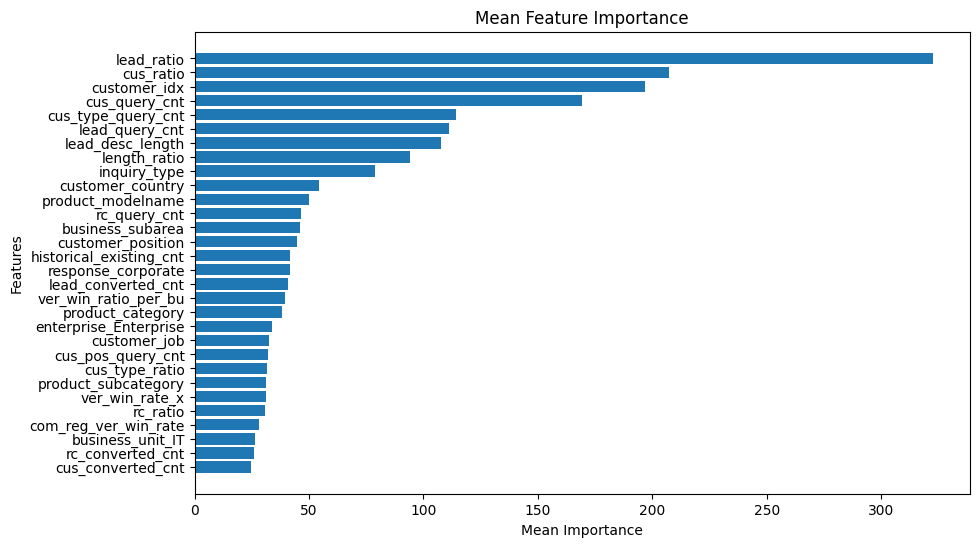

In [352]:
import numpy as np
import matplotlib.pyplot as plt

# 특징 중요도와 특징 이름을 정렬
top_features = 30
sorted_indices = np.argsort(-np.mean(feature_importance_list, axis=0))[::-1]
sorted_feature_names = [lgb_model.feature_name()[i] for i in sorted_indices][-top_features:]
sorted_mean_importance = np.mean(feature_importance_list, axis=0)[sorted_indices][-top_features:]

# 바 차트 그리기
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_mean_importance)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Mean Feature Importance')
plt.show()

### 테스트 데이터 예측

In [353]:
# 예측에 필요한 데이터 분리 0.3으로 했을 때 가장 많이 나옴.. 이게 맞나
test_pred = np.where(oof_test_preds >= 0.3, 1, 0)

In [354]:
sum(test_pred) # True로 예측된 개수 2064

2371

## 4. 제출하기

### 제출 파일 작성

In [355]:
df_test["is_converted"] = test_pred

In [356]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"]=df_test["is_converted"]

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**